In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

In [10]:
# Use the Inspector
inspector = inspect(engine)

# Use the Inspector print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date_tuple = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_dt = dt.datetime.strptime(last_date_tuple[0], '%Y-%m-%d')
last_date = last_date_dt.date()

one_year_ago_date = last_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns = ['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df_sorted = prcp_df.sort_values(by=['date'])
prcp_df_sorted

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


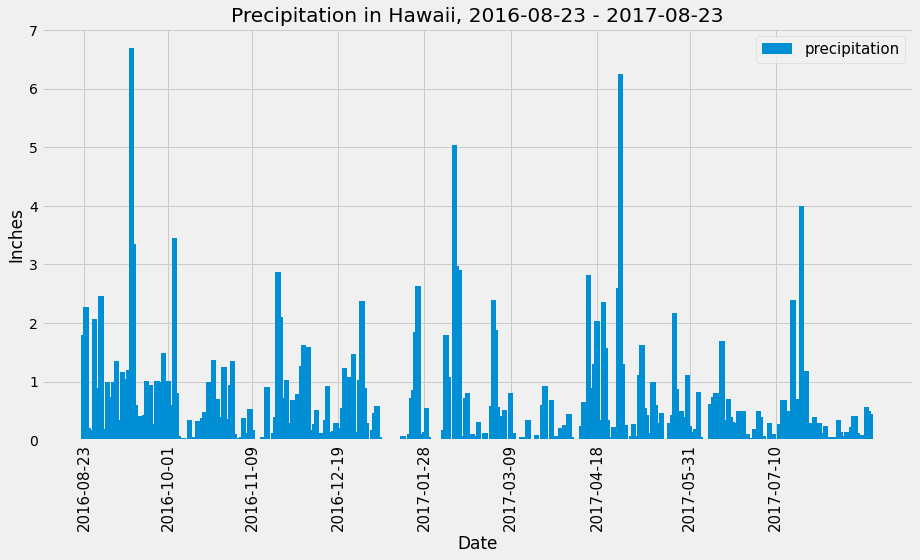

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize = (13, 8))
plt.bar(prcp_df_sorted.index, prcp_df_sorted['precipitation'], width=2.5)

# Add title, legned, xlabel, ylabel
plt.title(f'Precipitation in Hawaii, {one_year_ago_date} - {last_date}')
plt.legend(['precipitation'], loc="best",fontsize=15)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Inches', fontsize=17)


# Set xticks
xticks = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18','2017-05-31','2017-07-10'] 
plt.xticks(xticks, rotation=90, fontsize=15)

plt.tight_layout()

# Save the figure and Display the plot
plt.savefig(f'Images/Precipitation_in_Hawaii,_{one_year_ago_date}-{last_date}.png', bbox_inches='tight')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df_sorted.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Anlysis

In [14]:
# Use the Inspector print the column names and types
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.name).count()
print(f"The number of stations available in the dataset is {num_stations}.")

The number of stations available in the dataset is 9.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count()).\
                    group_by(Measurement.station).\
                    order_by(func.count().desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = active_stations[0][0]

print(f"The most active station is {most_active_station}.\n")

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

temp_data = session.query(*sel).\
            filter(Measurement.station == most_active_station).all()

for lowest_temp, highest_temp, avg_temp in temp_data:
    print(f'The most active station {most_active_station} temperature data:')
    print('--------------------------------------------------------------')
    print(f'The lowest temperature recorded is {lowest_temp}.')
    print(f'The highest temperature recorded is {highest_temp}.')
    print(f'The average temperature recorded is {avg_temp}.')

The most active station is USC00519281.

The most active station USC00519281 temperature data:
--------------------------------------------------------------
The lowest temperature recorded is 54.0.
The highest temperature recorded is 85.0.
The average temperature recorded is 71.66378066378067.


In [18]:
# Choose the station with the highest number of temperature observations.
highest_observations = session.query(Measurement.station, func.count()).\
                        group_by(Measurement.station).\
                        order_by(func.count().desc()).first()
highest_observations_station = highest_observations[0]

print(f"The station with the highest number of temperature observations is {highest_observations_station}.")

The station with the highest number of temperature observations is USC00519281.


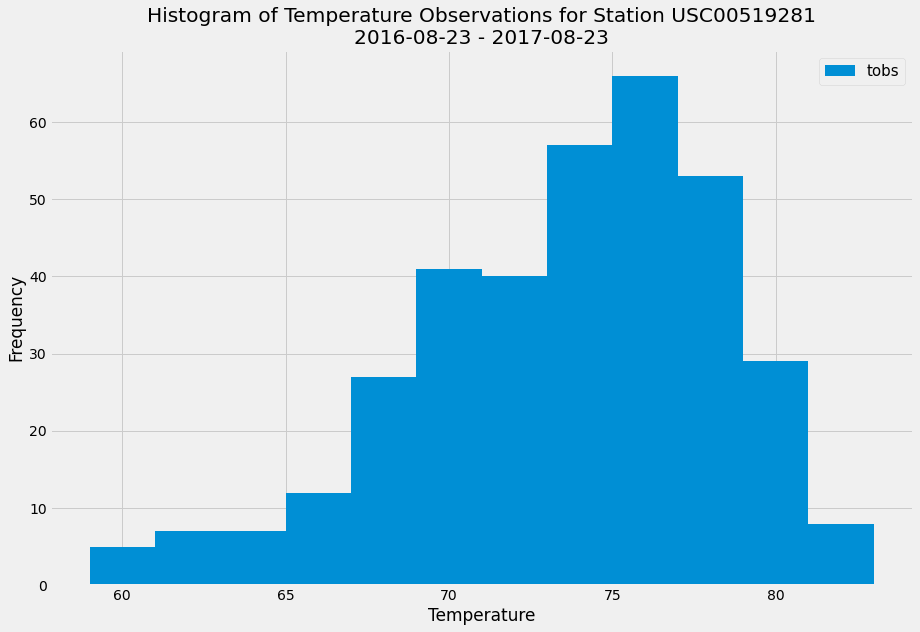

In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.station == highest_observations_station).\
            filter(Measurement.date >= one_year_ago_date).all()

# Change data to list
tobs_list = [data[0] for data in tobs_data]

# Plot the tobs data as a histogram
plt.figure(figsize = (13, 9))
plt.hist(tobs_list, bins=12)

# Add title, legned, xlabel, ylabel
plt.title(f'Histogram of Temperature Observations for Station {highest_observations_station}\n{one_year_ago_date} - {last_date}')
plt.legend(['tobs'], loc="best", fontsize=15)
plt.xlabel('Temperature', fontsize=17)
plt.ylabel('Frequency', fontsize=17)

plt.tight_layout()

# Save the figure and Display the plot
plt.savefig(f'Images/Histogram_of_Temperature_Observations_for_Station_{highest_observations_station}_{one_year_ago_date}_{last_date}', bbox_inches='tight')
plt.show()

## Bonus Challenge Assignment

## Trip Temperature Analysis

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = '2017-05-20'
trip_end_date = '2017-05-27'
trip_temps = calc_temps(trip_start_date, trip_end_date)
trip_temps

[(69.0, 74.97826086956522, 87.0)]

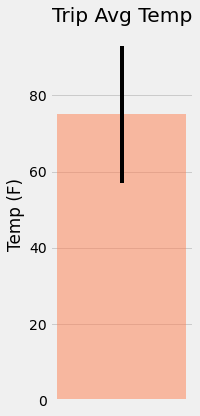

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]
peak_to_peak = max_temp - min_temp

x_pos = [1]

# Build the plot
fig, ax = plt.subplots(figsize = (3, 6))
ax.bar(x_pos, avg_temp, yerr=peak_to_peak, alpha=0.5, align='center', color='coral')
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
ax.set_xticks([])

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/trip_avg_temp.png', bbox_inches='tight')

plt.show()

## Daily Rainfall Average

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Perform a query to retrieve the data
sel = [Measurement.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]
trip_rainfall_results = session.query(*sel).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= trip_start_date).\
                    filter(Measurement.date <= trip_end_date).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

trip_rainfall_df = pd.DataFrame(trip_rainfall_results, columns = ['Station', 'Name', 'Total Amount of Rainfall', 'Latitude', 'Longitude', 'Elevation'])
trip_rainfall_df

,Station,Name,Total Amount of Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.29,21.33310,-157.80250,152.4
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",1.16,21.33556,-157.71139,19.5
2,USC00513117,"KANEOHE 838.1, HI US",0.99,21.42340,-157.80150,14.6
3,USC00519281,"WAIHEE 837.5, HI US",0.65,21.45167,-157.84889,32.9
4,USC00519397,"WAIKIKI 717.2, HI US",0.37,21.27160,-157.81680,3.0
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.29,21.52130,-157.83740,7.0


## Daily Temperature Average

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = '2017-05-20'
trip_end_date = '2017-05-27'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(trip_start_date, "%Y-%m-%d")
end = dt.datetime.strptime(trip_end_date, "%Y-%m-%d")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

# Stip off the year and save a list of %m-%d strings
dates_range = []
for date in date_generated:
    dates_range.append(date.strftime("%Y-%m-%d"))

dates_string = []
for date in dates_range:
    year, month, date = date.split('-')
    trip_date_string = f"{month}-{date}"
    dates_string.append(trip_date_string)

dates_string
# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normals_list = []
for date in dates_string:
    daily_normals_list.append(daily_normals(date)[0])
    
daily_normals_list

[(68.0, 73.89655172413794, 79.0),
 (64.0, 72.96428571428571, 80.0),
 (64.0, 74.45614035087719, 80.0),
 (68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normal_df = pd.DataFrame(daily_normals_list, columns = ['min_temp', 'avg_temp', 'max_temp'])
daily_normal_df['trip_dates'] = dates_string
daily_normal_df.set_index('trip_dates', inplace=True)
daily_normal_df

,min_temp,avg_temp,max_temp
trip_dates,,,
05-20,68.0,73.896552,79.0
05-21,64.0,72.964286,80.0
05-22,64.0,74.456140,80.0
05-23,68.0,74.948276,87.0
05-24,67.0,73.948276,79.0
05-25,68.0,74.275862,79.0
05-26,65.0,74.036364,82.0


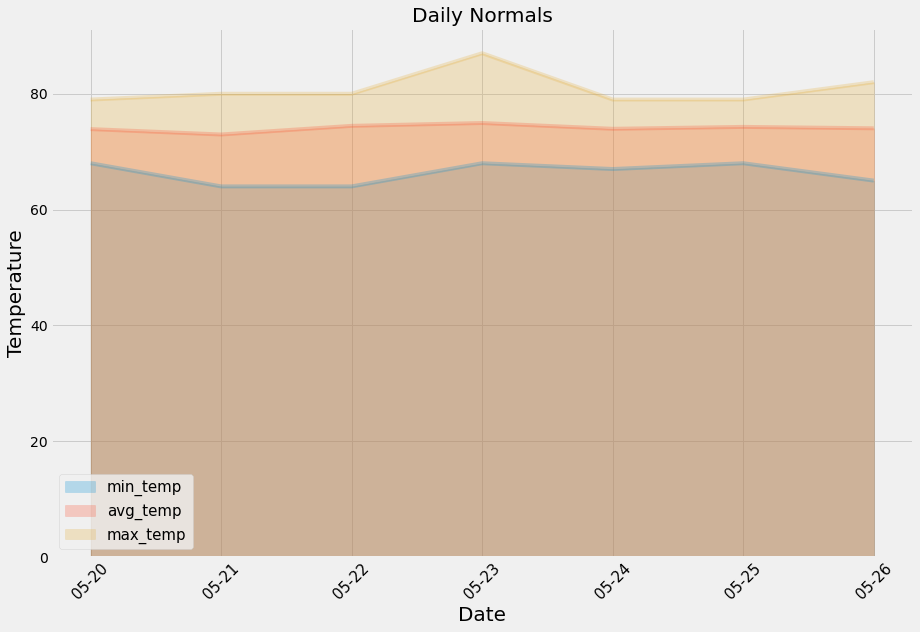

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normal_df.plot.area(stacked=False, figsize=(13,9), alpha=0.25)

# Add title, legned, xlabel, ylabel
plt.title(f'Daily Normals')
plt.legend(loc="best", fontsize=15)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Temperature', fontsize=20)
plt.xticks(rotation=45, fontsize=15)

plt.tight_layout()

# Save the figure and Display the plot
plt.savefig(f'Images/Daily_Normals_area_plot.png', bbox_inches='tight')
plt.show()

## Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

In [28]:
# Query the average temperature in June at all stations
avg_temp_june = session.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m", Measurement.date) == "06").all()

print(f"The average temperature in June is {avg_temp_june[0][0]}.")

The average temperature in June is 74.94411764705882.


In [29]:
# Query the average temperature in December at all stations
avg_temp_dec = session.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m", Measurement.date) == "12").all()

print(f"The average temperature in December is {avg_temp_dec[0][0]}.")

The average temperature in December is 71.04152933421226.


### paired t-test
#### Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

A t-test is used to test the difference between means to determine if there is a significant difference between the two groups.

A paired t-test compares the means of the related groups, and an unpaired t-test compares the means of different groups.
A paired t-test is designed to compare the means of the same group or item under two separate scenarios. An unpaired t-test compares the means of two independent or unrelated groups.

In this case, comparing the means between the average temperature in June and December at the same places in Hawaii, **an paired t-test is more suitable** to use as it is to compare the same places' temperatures at different times. 

In [30]:
# Query the temperatures in June and convert the results into a list
june_temp = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
june_temp_list = list(np.ravel(june_temp))

# Query the temperatures in December and convert the results into a list
dec_temp = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()
dec_temp_list = list(np.ravel(dec_temp))

# Remove Null values
june_temp = []
for temp in june_temp_list:
    if temp != None:
        june_temp.append(temp)
        
dec_temp = []
for temp in dec_temp_list:
    if temp != None:
        dec_temp.append(temp)

print(len(june_temp), len(dec_temp))

1700 1517


In [31]:
# paired t-test
from scipy import stats

stats.ttest_rel(june_temp[0:1500], dec_temp[0:1500])

Ttest_relResult(statistic=34.69833028869736, pvalue=3.864098966773339e-194)

### t-test results
* With the result, t-statistic value is 34.698, and the p-value is less than 0.05, the null hypothesis is rejected
* There is a significant difference between the two population means (the temperature in June and December)
* This difference is unlikely to be caused by sampling error or chance.